In [89]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict,Annotated,Literal
from dotenv import load_dotenv, find_dotenv
from pydantic import BaseModel, Field
import operator
from langchain_core.messages import SystemMessage,HumanMessage

In [90]:
_: bool = load_dotenv(find_dotenv())

generator_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")
evaluator_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")
optimizer_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

In [91]:
class LinkedInState(TypedDict):
    topic:str
    post:str
    evaluation:Literal["approved","needs_improvement"]
    feedback:str
    iteration:int
    max_iteration:int

    post_history:Annotated[list[str],operator.add]
    feedback_history:Annotated[list[str],operator.add]


In [92]:
def generate_post(state:LinkedInState):

    messages=[
        SystemMessage(content="You are a professional writing assistant."),
        HumanMessage(content=f'''
                    Write a concise and engaging LinkedIn post about {state["topic"]}.
                    Your goal is to educate or inspire professionals in a friendly, insightful tone.
                    Use simple language, avoid jargon, and include a call to action or thought-provoking question at the end.
                    Limit to 150–200 words.

                    Rules:
                    -SIMPLE
                    -This is version {state["iteration"]+1}
                    ''')
    ]
    response=generator_llm.invoke(messages).content

    return {"post":response,"post_history":[response]}

In [93]:
class PostEvaSchema(BaseModel):
    evaluation:Literal["approved","needs_improvement"]=Field(..., description='Final evaluation')
    feedback: str =Field(...,description="feedback for the post")
    #score:int=Field(...,ge=0,le=5,description="Total score from rubric (0 to 5)")
 

In [94]:
structured_evaluator_llm=evaluator_llm.with_structured_output(PostEvaSchema)

In [95]:
def evaluate_post(state:LinkedInState):
    #prompt:
    message=[
            SystemMessage(
        content=(
            "You are a brutally honest, no-fluff LinkedIn post critic. "
            "You evaluate professional posts based on clarity, value, originality, and engagement potential. "
            "You don’t tolerate vague motivational fluff, repackaged clichés, or corporate buzzword soup. "
            "You are concise, constructive, and never overly kind."
        )
    ),
    HumanMessage(
        content=f'''
    Evaluate the following LinkedIn post:

    Post: "{state['post']}"

    Use the criteria below to evaluate the post:

    1. **Clarity** – Is the message easy to understand without re-reading?  
    2. **Value** – Does it offer a useful insight, lesson, or actionable takeaway?  
    3. **Originality** – Is this perspective fresh or has it been said a thousand times?  
    4. **Engagement** – Would professionals be inclined to comment, share, or react?  
    5. **Structure** – Does it have a hook, body, and a strong ending (e.g., CTA or thought-provoking question)?

    **Auto-reject if:**
    - It sounds like a generic self-congratulation or humblebrag  
    - It relies on overused phrases like “Just putting this out there” or “Let that sink in”  
    - It’s longer than 400 characters (typical LinkedIn post limit)  
    - It ends in an empty motivational line without substance

    ### Respond ONLY in structured format:

    - evaluation: "approved" or "needs_improvement"  
    - feedback: One concise paragraph (max 100 words) analyzing the post’s strengths and weaknesses
    '''
        )
    ]
        
    response=structured_evaluator_llm.invoke(message)
    return {'evaluation':response.evaluation,'feedback':response.feedback,"feedback_history":[response.feedback]}



In [96]:
def optimizer(state:LinkedInState):
    messages = [
    SystemMessage(
        content="You rewrite LinkedIn posts to improve clarity, originality, and engagement, based on critical feedback. You remove fluff, avoid clichés, and aim for professional but conversational tone."
    ),
    HumanMessage(
        content=f"""
    Improve the LinkedIn post based on this feedback:
    "{state['feedback']}"

    Topic: "{state['topic']}"
    Original Post:
    {state['post']}

    Re-write it as a clear, concise, and high-engagement LinkedIn post.
    - Keep it under 400 characters.
    - Avoid empty motivational clichés.
    - Start with a strong hook.
    - End with a call to action or thought-provoking insight.
    - don't Use "Revised"
    """
        )
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'post': response, 'iteration': iteration, 'post_history': [response]}

In [97]:
def route_evaluation(state:LinkedInState):
    if state['evaluation']== 'approved' or state['iteration']>=state["max_iteration"]:
        return 'approved'
    else:
        return "needs_improvement"

In [98]:
graph=StateGraph(LinkedInState)


graph.add_node('generate_post',generate_post)
graph.add_node("evaluate_post",evaluate_post)
graph.add_node("optimizer",optimizer)


graph.add_edge(START,"generate_post")
graph.add_edge("generate_post","evaluate_post")
graph.add_conditional_edges("evaluate_post",route_evaluation,{'approved':END,"needs_improvement":"optimizer"})
graph.add_edge("optimizer","evaluate_post")


workflow=graph.compile()

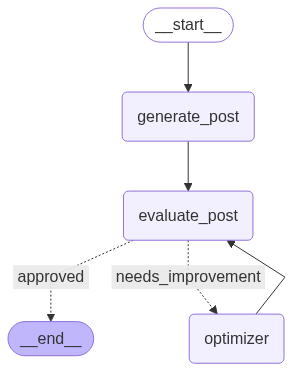

In [99]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [100]:
initial_state={
    'topic':"AI in healthcare",
    "iteration":1,
    "max_iteration":5
}
workflow.invoke(initial_state)

{'topic': 'AI in healthcare',
 'post': 'AI is cutting diagnosis times, but are we ready for the ethical implications of algorithms making life-altering decisions? What safeguards are crucial for responsible AI in healthcare? #AIinHealthcare #HealthcareAI',
 'evaluation': 'approved',
 'feedback': "The post is clear and raises a relevant question about AI ethics in healthcare. It offers value by prompting discussion on necessary safeguards. While the topic isn't entirely new, it remains pertinent. The question format encourages engagement, and the hashtags are appropriate. The post is within the character limit and avoids generic filler.",
 'iteration': 2,
 'max_iteration': 5,
 'post_history': ["## AI: The Future of Healthcare is Now 🚀\n\nAI is no longer a futuristic fantasy; it's actively transforming healthcare! From speeding up diagnoses and personalizing treatments to streamlining administrative tasks, AI is helping doctors and hospitals work smarter, not harder.\n\nImagine a world w